# Image Loader
We want to change the image loader from a SQLite database to just simple calls.

Within the `project.json` instruction file it lists `database_path` where the `.sqlite` file is found.
We will replace this with just a call to the images itself and also metadata in its raw form from Danbooru.

In [3]:
import os
import sys
import csv
import json
from pprint import pprint
import collections
import pandas as pd
import tensorflow as tf
import glob
import sqlite3
import matplotlib.pyplot as plt

import deepdanbooru as dd

import pickle

data_dir = os.path.join("..", "data")
# danbooru_img_dir = os.path.join(data_dir, "danbooru", "38986_61452_upload_danbooru-images", "danbooru-images", "0059")
danbooru_meta_dir = os.path.join(data_dir, "danbooru", "danbooru2019", "metadata")
danbooru_project_name = "project-small"

# Project
project_name = "danbooru-dev"
project_dir = os.path.join("..", project_name)

# Tag File
tag_path = os.path.join(project_dir, "tags.txt")

# Tfrecord
tfrecord_dir = os.path.join(data_dir, "preprocessed", danbooru_project_name)

# Metadata
output_metadata_dir = os.path.join(data_dir, "preprocessed", danbooru_project_name)
output_metadata_filename = "metadata.pkl"
output_metadata_path = os.path.join(output_metadata_dir, output_metadata_filename)
print("output_metadata_path: \n\t{}".format(output_metadata_path))

# Project Folder
sqlite_dir = os.path.join(data_dir, "sqlite")
sqlite_path = os.path.join(sqlite_dir, "danbooru-dev.sqlite")
print("sqlite_path: \n\t{}".format(sqlite_path))

# Make project name subfolder
if not os.path.exists(tfrecord_dir):
    print("Making folder: {}".format(tfrecord_dir))
    os.makedirs(tfrecord_dir)

output_metadata_path: 
	..\data\preprocessed\project-small\metadata.pkl
sqlite_path: 
	..\data\sqlite\danbooru-dev.sqlite


## SQL Call
In order to get a list of files to get it uses the following query where `minimum_tag_count` is a count of its occurent found in `project.json` attribute `minimum_tag_count`:
```sql
SELECT 
    md5, 
    file_ext, 
    tag_string 
FROM 
    posts 
WHERE 
    (file_ext = 'png' OR file_ext = 'jpg' OR file_ext = 'jpeg') 
    AND (tag_count_general >= $minimum_tag_count) 
ORDER BY 
    id
```

Let's convert the metadata into a SQLite database

In [2]:

def read_metadata(file_path):
    lines = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        line = file.readline()
        while line:
            line = json.loads(file.readline())
            lines[line['id']] = line
    return lines

def read_metadata_dict(file_path, top_n=None, filter_attributes=None, filter_tag=None):
    data = dict()
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            l = json.loads(line)
            if filter_attributes:
                l = {k: l.get(k, None) for k in filter_attributes}
                l['tags'] = [t['name'] for t in l['tags']]
                
            
            if filter_tag:
                if len([l for l in l['tags'] if l in filter_tag]):
                    data[l['id']] = l
            else:
                data[l['id']] = l
    return data


# Let's look at 2019
metadata_glob = os.path.join(danbooru_meta_dir, "*", "2019*")
metadata_list = glob.glob(metadata_glob)
print("metadata_list n = {}\n\t{}".format(len(metadata_list), metadata_glob))

# data_meta_0 = read_metadata_dict(metadata_list[0])
# data_meta_1 = read_metadata_dict(metadata_list[1])

# data_meta = data_meta_0

metadata_list n = 13
	..\data\danbooru\danbooru2019\metadata\*\2019*


In [3]:
# Preview
n_images = len(list(data_meta.keys()))
print("\t There are n = {} images".format(n_images))

for i, (k, v) in enumerate(data_meta.items()):
    pprint(v)
    break

	 There are n = 285962 images
{'approver_id': '10676',
 'created_at': '2008-06-10 02:53:12.6256 UTC',
 'down_score': '0',
 'favs': ['89268', '68238', '117203', '169955'],
 'file_ext': 'jpg',
 'file_size': '21258',
 'has_children': False,
 'id': '263159',
 'image_height': '575',
 'image_width': '363',
 'is_banned': False,
 'is_deleted': False,
 'is_flagged': False,
 'is_note_locked': False,
 'is_pending': False,
 'is_rating_locked': False,
 'is_status_locked': False,
 'last_commented_at': '1970-01-01 00:00:00 UTC',
 'last_noted_at': '1970-01-01 00:00:00 UTC',
 'md5': 'c401bc0081a6952acfc1ad2f65d51b82',
 'parent_id': '0',
 'pixiv_id': '0',
 'pools': [],
 'rating': 's',
 'score': '0',
 'source': '',
 'tags': [{'category': '0', 'id': '470575', 'name': '1girl'},
          {'category': '0', 'id': '16751', 'name': 'bangs'},
          {'category': '0', 'id': '11826', 'name': 'barefoot'},
          {'category': '0', 'id': '537684', 'name': 'blunt_bangs'},
          {'category': '0', 'id': '1686

# Make SQLite DB

In [6]:
# Parameters
# source_path = None
start_id = 1
end_id = sys.maxsize
use_deleted = False 
chunk_size = 5000000 
overwrite = True
vacuum = False
output_path = sqlite_path


def make_training_database_metadata(data_meta, output_path, start_id, end_id,
                           use_deleted, chunk_size, overwrite, vacuum):

    print("Writing data_meta into output_path: \n\t{}".format(output_path))
    
    n_images = len(list(data_meta.keys()))
    print("\tThere are n = {} images".format(n_images))

    if os.path.exists(output_path):
        if overwrite:
            os.remove(output_path)
        else:
            print("\tIf table exists then inserting new rows")
#             raise Exception(f'{output_path} is already exists.')

    # Connect
    output_connection = sqlite3.connect(output_path)
    output_connection.row_factory = sqlite3.Row
    output_cursor = output_connection.cursor()


    table_name = 'posts'
    id_column_name = 'id'
    md5_column_name = 'md5'
    extension_column_name = 'file_ext'
    tags_column_name = 'tag_string'
    tag_count_general_column_name = 'tag_count_general'
    rating_column_name = 'rating'
    score_column_name = 'score'
    deleted_column_name = 'is_deleted'


    # Create output table
    print('\tCreating table ...')
    output_cursor.execute(f"""CREATE TABLE IF NOT EXISTS {table_name} (
        {id_column_name} INTEGER NOT NULL PRIMARY KEY,
        {md5_column_name} TEXT,
        {extension_column_name} TEXT,
        {tags_column_name} TEXT,
        {tag_count_general_column_name} INTEGER,
        {rating_column_name} TEXT,
        {score_column_name} FLOAT,
        {deleted_column_name} BOOL
        )""")
    output_connection.commit()
    print('\tCreating table is complete.')

    current_start_id = start_id

    # Hold
    insert_params = []

    # Preview
    print("\tParsing data meta")
    for i, (k, row) in enumerate(data_meta.items()):
#         pprint(row)
            
        post_id = row['id']
        md5 = row['md5']
        extension = row['file_ext']
        tags = row['tags']
        general_tag_count = len(tags)
        rating = row['rating']
        score = row['score']
        is_deleted = row['is_deleted']

        # Convert tags into a list of string with white space separated
        tags = [t['name'] for t in tags]
        tags = " ".join(tags)

        if is_deleted and not use_deleted:
            continue

        # Add rating to tags
        if rating == 's':
            tags += f' rating:safe'
        elif rating == 'q':
            tags += f' rating:questionable'
        elif rating == 'e':
            tags += f' rating:explicit'
            

        insert_params.append(
            (post_id, md5, extension, tags, general_tag_count, rating, score, is_deleted))

        

    if insert_params:
        print('\tInserting ...')
        output_cursor.executemany(
            f"""INSERT INTO {table_name} (
            {id_column_name},{md5_column_name},{extension_column_name},{tags_column_name},{tag_count_general_column_name},{rating_column_name},{score_column_name},{deleted_column_name})
            values (?, ?, ?, ?, ?, ?, ?, ?)""", insert_params)
        output_connection.commit()
    
#     current_start_id = rows[-1][id_column_name] + 1

    if vacuum:
        print('\tVacuum ...')
        output_cursor.execute('vacuum')
        output_connection.commit()
    
    print("\tDone. Closing Connection.")
    output_connection.close()
    
    
def make_training_database_metadata_list(metadata_list):
    n_meta = len(metadata_list)
    overwrite = True
    for i, metadata_file_path in enumerate(metadata_list):
        print("Working on file [{} of {}] \n\t{}".format(i + 1, n_meta, metadata_file_path))
        
        # Read metadatafile
        data_meta = read_metadata_dict(metadata_file_path)

        # Insert
        make_training_database_metadata(
            data_meta = data_meta, 
            output_path = sqlite_path,
            start_id = 1,
            end_id = sys.maxsize,
            use_deleted = False,
            chunk_size = 5000000,
            overwrite = i == 0,  # Onlt overwirte on the first call
            vacuum = False
        )
    
    
def make_training_database_metadata_glob(
    data_meta_glob, 
    output_path,
    start_id = 1,
    end_id = sys.maxsize,
    use_deleted = False,
    chunk_size = 5000000,
    overwrite = True,
    vacuum = False):
    """
    Make training database from the danbooru metadata.
    """
    
    metadata_list = glob.glob(data_meta_glob)
    print("metadata_list n = {}".format(len(metadata_list)))
    
    for i, metadata_file_path in enumerate(metadata_list):
        print("\tWorking on file [{} of {}] \n\t{}".format(i + 1, n_meta, metadata_file_path))
        
        # Read metadatafile
        data_meta = read_metadata_dict(metadata_file_path)
        
        # overwrite=True - Only overwrite the first creation, else append
        # overwrite=False - Append, but errors may happen if ID is non-unique
        overwrite_first = i == 0 if overwrite else False

        # Insert
        make_training_database_metadata(
            data_meta = data_meta, 
            output_path = output_path,
            start_id = start_id,
            end_id = end_id,
            use_deleted = use_deleted,
            chunk_size = chunk_size,
            overwrite = overwrite_first,
            vacuum = vacuum
        )
    
        

    
def query_db(sqlite_path, query):
    
    output_connection = sqlite3.connect(sqlite_path)
    
    df = pd.read_sql_query(query, output_connection)
    
    output_connection.close()
    
    return df


# # Insert
# make_training_database(
#     data_meta = data_meta, 
#     output_path = sqlite_path,
#     start_id = 1,
#     end_id = sys.maxsize,
#     use_deleted = False,
#     chunk_size = 5000000,
#     overwrite = True,
#     vacuum = False
# )


# make_training_database_metadata_list(metadata_list)

In [4]:

query_df = query_db(
    sqlite_path=sqlite_path, 
    query="""
    SELECT 
        * 
    FROM 
        posts 
    WHERE
        tag_string like '%angel%'
    LIMIT 10
    """)
print(query_df)

query_df = query_db(
    sqlite_path=sqlite_path, 
    query="""
    SELECT 
        count(*) as post_count
    FROM 
        posts 
    """)
print(query_df)

query_df = query_db(
    sqlite_path=sqlite_path, 
    query="""
    SELECT 
        min(id) as id_min,
        max(id) as id_max
    FROM 
        posts 
    """)
print(query_df)

     id                               md5 file_ext  \
0   114  e4d07975db4422ad0d8d446f3330760d      jpg   
1   203  81c4ca43f1a132bd7805324a55ae8f21      gif   
2   282  33c9d293a127531894ec7688a61c641f      jpg   
3   483  1b72732e7dde821eeb65175c41c91ea9      jpg   
4   757  a2a9f86672b091027e685452c4835013      jpg   
5   772  06d09a354dcfc5ad7a6c47f4f07e532d      jpg   
6   910  712e1d667038267c3072ab4dd495a27f      jpg   
7   989  3f39121b0919f1fa91ff562abd96184a      jpg   
8   993  e0ed4a26adaa734ba3f8e9d6881fd85e      png   
9  1035  c0a14b4c7f67963e382a33d5430a03ef      jpg   

                                          tag_string  tag_count_general  \
0  3girls blonde_hair blue_eyes blue_hair blush b...                 27   
1  1girl angel aqua_eyes aruma_(shinrabanshou) bl...                 20   
2  2girls ;d angel_wings belt blue_eyes blush bro...                 37   
3  1girl black_legwear blue_hair blue_skirt brown...                 16   
4  1girl :3 armlet artist_requ

# Download Images
Now that we've successfully created a sqlite database from the metadata let's download the image.

Write text file for `rsync` option `--include-from=<txt-file>`

In [22]:
%%time
print("The length of data_meta is {}".format(len(data_meta.keys())))

rsync_instructions_dir = os.path.join("..", "data", "filters")
rsync_filename = "danbooru_dev.txt"
rsync_path = os.path.join(rsync_instructions_dir, rsync_filename)
print(rsync_path)

# Write out file
with open(rsync_path, 'w') as file:
    # look only at the original
    file.write("original" + "\n" + "original/*/" + "\n")
    for i, (k, v) in enumerate(data_meta.items()):
        include_filename = v['id'] + "." + v['file_ext']
        file.write(include_filename + "\n")

The length of data_meta is 285962
..\data\filters\danbooru_dev.txt
Wall time: 403 ms


Now we need to open up a console window and run the following.
If you are on a linux based OS then run in console:
```bash
rsync --verbose --recursive --prune-empty-dirs \
	--include-from='data/filters/danbooru_dev.txt' \
	--exclude='*' \
	rsync://78.46.86.149:873/danbooru2019/ /mnt/e/data/danbooru/danbooru2019/
```




# Test Subset
Now that we have the ability to make SQLite databases using the metadata, let's make a full pipeline using a subset of images just to make sure we can train.

We can make a subset SQLite using the built-in function
```bash
deepdanbooru make-training-database [your_dataset_sqlite_path] [your_filtered_sqlite_path]
```


In [8]:
filter_tag = 'dragon_ball'

query_df = query_db(
    sqlite_path=sqlite_path, 
    query="""
    SELECT 
        id
    FROM 
        posts 
    WHERE
        tag_string like '%{filter_tag}%'
    """.format(filter_tag=filter_tag))
print(query_df)

# # Subset the database
# data_meta_subset = {str(id): data_meta[str(id)] for id in query_df.id.values}
# len(data_meta_subset.keys())

           id
0        1589
1        6537
2        7937
3        8050
4        9645
...       ...
6390  3736821
6391  3736833
6392  3738032
6393  3739116
6394  3741600

[6395 rows x 1 columns]


## Filter to IDs with Images

In [11]:
# List of all files
id_filter_list = query_df.id.values.tolist()
print("id_filter_list \n\tn={}".format(len(id_filter_list)))

# Filter to only files that exist in image directory
image_path_list = glob.glob(os.path.join("G:/AI/shazam/DeepDanbooru/data/danbooru/danbooru2019/original", "*/*"))
print("image_path_list \n\tn={}".format(len(image_path_list)))

image_dict = dict()
for img_path in image_path_list:
    # img path
    img_filename = os.path.basename(img_path)
    img_id, img_ext = os.path.splitext(img_filename)
    image_dict[img_id] = img_path
    print(type(img_id))
    break
    
    

id_filter_list = [i for i in id_filter_list if str(i) in image_dict.keys()]
print("id_filter_list \n\tn={}".format(len(id_filter_list)))
type(id_filter_list[0])

id_filter_list 
	n=6395
image_path_list 
	n=8055
<class 'str'>
id_filter_list 
	n=1


int

In [19]:


def make_training_database_tag(source_path, output_path, start_id, end_id,
                           use_deleted, chunk_size, overwrite, vacuum, tag_filter=None, id_filter_list=[]):
    '''
    Make sqlite database for training. Also add system tags.
    '''
    if source_path == output_path:
        raise Exception('Source path and output path is equal.')

    if os.path.exists(output_path):
        if overwrite:
            os.remove(output_path)
        else:
            raise Exception(f'{output_path} is already exists.')

    source_connection = sqlite3.connect(source_path)
    source_connection.row_factory = sqlite3.Row
    source_cursor = source_connection.cursor()

    output_connection = sqlite3.connect(output_path)
    output_connection.row_factory = sqlite3.Row
    output_cursor = output_connection.cursor()

    table_name = 'posts'
    id_column_name = 'id'
    md5_column_name = 'md5'
    extension_column_name = 'file_ext'
    tags_column_name = 'tag_string'
    tag_count_general_column_name = 'tag_count_general'
    rating_column_name = 'rating'
    score_column_name = 'score'
    deleted_column_name = 'is_deleted'

    # Create output table
    print('Creating table ...')
    output_cursor.execute(f"""CREATE TABLE {table_name} (
        {id_column_name} INTEGER NOT NULL PRIMARY KEY,
        {md5_column_name} TEXT,
        {extension_column_name} TEXT,
        {tags_column_name} TEXT,
        {tag_count_general_column_name} INTEGER )""")
    output_connection.commit()
    print('Creating table is complete.')

    current_start_id = start_id
    
    tag_filter_sql = ""
    if tag_filter:
        tag_filter_sql = " AND tag_string like '%{tag_filter}%' ".format(tag_filter=tag_filter)

    while True:
        print(
            f'Fetching source rows ... ({current_start_id}~)')
        source_cursor.execute(
            f"""SELECT
                {id_column_name},{md5_column_name},{extension_column_name},{tags_column_name},{tag_count_general_column_name},{rating_column_name},{score_column_name},{deleted_column_name}
            FROM {table_name} WHERE ({id_column_name} >= ?) {tag_filter_sql} ORDER BY {id_column_name} ASC LIMIT ?""",
            (current_start_id, chunk_size))

        rows = source_cursor.fetchall()

        if not rows:
            break

        insert_params = []

        for row in rows:
            post_id = row[id_column_name]
            md5 = row[md5_column_name]
            extension = row[extension_column_name]
            tags = row[tags_column_name]
            general_tag_count = row[tag_count_general_column_name]
            rating = row[rating_column_name]
            score = row[score_column_name]
            is_deleted = row[deleted_column_name]
            
            # Filter List
            if len(id_filter_list):
                if post_id in id_filter_list:
                    insert_params.append(
                        (post_id, md5, extension, tags, general_tag_count))
            else:
                insert_params.append(
                    (post_id, md5, extension, tags, general_tag_count))
                

        if insert_params:
            print('Inserting ...')
            output_cursor.executemany(
                f"""INSERT INTO {table_name} (
                {id_column_name},{md5_column_name},{extension_column_name},{tags_column_name},{tag_count_general_column_name})
                values (?, ?, ?, ?, ?)""", insert_params)
            output_connection.commit()

        current_start_id = rows[-1][id_column_name] + 1

        if current_start_id > end_id or len(rows) < chunk_size:
            break

    if vacuum:
        print('Vacuum ...')
        output_cursor.execute('vacuum')
        output_connection.commit()

    source_connection.close()
    output_connection.close()

# Make a subset
sqlite_path_subset = os.path.join(sqlite_dir, "danbooru-dev-subset.sqlite")

# Insert
make_training_database_tag(
    source_path = sqlite_path, 
    output_path = sqlite_path_subset,
    start_id = 1,
    end_id = sys.maxsize,
    use_deleted = False,
    chunk_size = 5000000,
    overwrite = True,
    vacuum = False,
    tag_filter = "dragon_ball",
    id_filter_list = id_filter_list
)

Creating table ...
Creating table is complete.
Fetching source rows ... (1~)
Inserting ...


### Preview Subset Table

In [7]:
# Subset
query_df = query_db(
    sqlite_path=sqlite_path_subset, 
    query="""
    SELECT 
        count(*) as post_count
    FROM 
        posts 
    """)
print(query_df)


   post_count
0        6395


## Make `tags.txt`

In [9]:
# Subset
query_df = query_db(
    sqlite_path=sqlite_path_subset, 
    query="""
    SELECT 
        tag_String
    FROM 
        posts 
    """)
print(query_df)


                                             tag_string
0     1girl bandaid bandaid_on_knee blue_hair blush ...
1     2boys acdc artist_request beavis beavis_and_bu...
2     1boy 1girl apron armpits arms_behind_head bald...
3     artist_request color_connection dodoria dragon...
4     1boy 1girl blush bow brown_hair crossover drag...
...                                                 ...
6390  1boy bangs black_shirt blue_eyes blue_jacket c...
6391  4boys black_hair bowl_cut cafe cape dragon_bal...
6392  1girl android_21 breasts checkered checkered_d...
6393  1girl alternate_eye_color android_21 bangle bl...
6394  1girl ahoge alternate_costume alternate_hairst...

[6395 rows x 1 columns]


In [27]:

# Get tags into a list
tag_list = [t for tl in query_df.tag_string for t in tl.split()]
print("tag_list n = {}".format(len(tag_list)))

# Count tag occurences and count
tag_counts = collections.Counter(tag_list)
print("tag_counts n = {}".format(len(tag_counts)))

# Filter tags  by if they have 
min_tag_count = 20
tag_list_sub = [k for k, v in dict(tag_counts).items() if v >= min_tag_count]
print("tag_list_sub n = {}".format(len(tag_list_sub)))

# Remove the filter tag since in one-hot it will always be one
tag_list_sub = [t for t in tag_list_sub if t != "dragon_ball"]
print("tag_list_sub n = {}".format(len(tag_list_sub)))

# Write to file
print("Writing tags to \n\t{}".format(tag_path))

# Write out file
with open(tag_path, 'w') as file:
    for t in tag_list_sub:
        file.write(t + "\n")
        

tag_list n = 219381
tag_counts n = 13594
tag_list_sub n = 1212
tag_list_sub n = 1211
Writing tags to 
	..\danbooru-dev\tags.txt



# Project Creation Process
Let us make the project

## Step 1
Create training project folder
```bash
deepdanbooru create-project danbooru-dev
```

## Step 2
Modify `project.json` in the project folder. You should change `database_path` setting to your actual sqlite file path.

In this notebook this is found in `sqlite_path_subset` but the absolute path of the folder.
For example `G:/AI/shazam/DeepDanbooru/data/sqlite/danbooru-dev-subset.sqlite`

Also, if you downloaded the image somewhere else on your system add to the `project.json` the attribute `image_folder_path` with the absolute path to the
images with 3 digit has subfolder `"image_folder_path": "G:/AI/shazam/DeepDanbooru/data/danbooru/danbooru2019/original"`


## Step 3
Train the project:
```bash
deepdanbooru train-project danbooru-dev
```

In [8]:
image_path_list = glob.glob(os.path.join("G:/AI/shazam/DeepDanbooru/data/danbooru/danbooru2019/original", "*/*"))
print(len(image_path_list))
image_path_list[1]

image_dict = dict()
for img_path in image_path_list:
    # img path
    img_filename = os.path.basename(img_path)
    img_id, img_ext = os.path.splitext(img_filename)
    image_dict[img_id] = img_path
    

for k, v in image_dict.items():
    print(type(k))
    print(k)
    print(v)
    break

8055
<class 'str'>
162000
G:/AI/shazam/DeepDanbooru/data/danbooru/danbooru2019/original\0000\162000.jpg


# Prediction
Once the model is trained, let's look at some of the results.

### Load Model

In [18]:

# Load Model
project_dir
model_pretrained_name = "model-efficientnet_b0.h5"
model_pretrained_path = os.path.join(project_dir, model_pretrained_name)
print("Loading model from model_pretrained_path: \n\t{}".format(model_pretrained_path))
# model = dd.project.load_model_from_project(project_path=project_dir, compile_model=False)
model = tf.keras.models.load_model(model_pretrained_path, compile=False)

Loading model from model_pretrained_path: 
	..\danbooru-dev\model-efficientnet_b0.h5


### Prepare Prediction Dataset

In [21]:

# Tags
tags_path = os.path.join(project_dir, "tags.txt")
tags = dd.data.load_tags(tags_path)
print("tags n = {}".format(len(tags)))

# Input Shape
width = model.input_shape[2]
height = model.input_shape[1]
print("model input_shape {}".format(model.input_shape))

# Plot
def plot_image(image, title=None):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)
    fig.show(image)


# Get a sample of images and place them
sqlite_path_subset = os.path.join(sqlite_dir, "danbooru-dev-subset.sqlite")
tag_filter = "dragon_ball"
query_sample = '''
SELECT 
    *
FROM 
    posts
WHERE
    tag_string like '%{tag_filter}%'
ORDER BY 
    random() 
LIMIT 1
'''.format(tag_filter=tag_filter)
img_sample_df = query_db(
    sqlite_path=sqlite_path_subset, 
    query=query_sample)
print(img_sample_df)



tags n = 1211
model input_shape (None, 240, 240, 3)
        id                               md5 file_ext  \
0  3607091  c3fd44f1a153d1d5c583ef4d169cff3a      jpg   

                                          tag_string  tag_count_general  
0  armor bardock bosstseng chinese_text clenched_...                 22  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tags of G:/AI/shazam/DeepDanbooru/data/danbooru/danbooru2019/original\0091\3607091.jpg:
                    tag         score
1096  dragon_ball_super  1.000000e+00
20          rating:safe  1.000000e+00
76          blonde_hair  1.000000e+00
65                 solo  1.000000e+00
4         dragon_ball_z  1.000000e+00
113           blue_eyes  1.000000e+00
32                 1boy  1.000000e+00
134          android_18  1.000000e+00
25           male_focus  1.000000e+00
0                 1girl  8.929923e-14
769     grey_background  0.000000e+00
770              formal  0.000000e+00
815              mohawk  0.000000e+00
814    military_uniform  0.000000e+00
813            military  0.000000e+00
812       holding_sword  0.000000e+00
811    headwear_removed  0.000000e+00
810        baseball_cap  0.000000e+00
809          idolmaster  0.000000e+00
808          headphones  0.000000e+00
['armor bardock bosstseng chinese_text clenched_hands comic dragon_ball dragon_ball_minus facial_scar gine greysca

C:\Users\serap\.conda\envs\danbooru\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


,tag,id,ext,img_path,score
0,armor,3607091,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.0
1,bardock,3607091,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.0
2,bosstseng,3607091,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.0
3,chinese_text,3607091,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.0
4,clenched_hands,3607091,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.0
5,comic,3607091,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.0
6,dragon_ball,NaN,NaN,NaN,NaN
7,dragon_ball_minus,3607091,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.0
8,facial_scar,3607091,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.0
9,gine,3607091,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.0


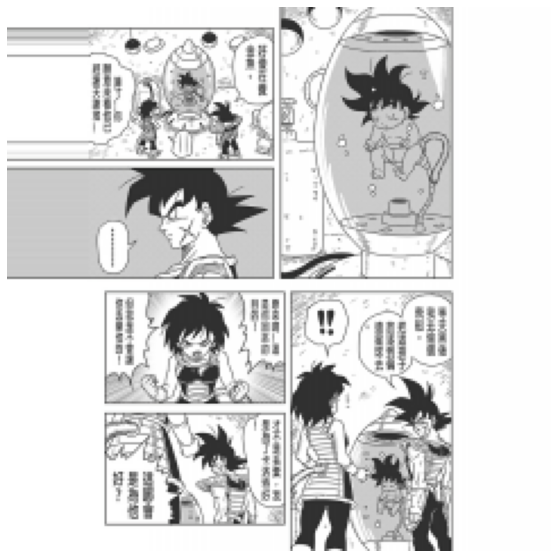

In [22]:
threshold = 0.0

# Filter images folder for our sample
image_path_list = glob.glob(os.path.join("G:/AI/shazam/DeepDanbooru/data/danbooru/danbooru2019/original", "*/*"))
pred_dict = list()
for img_path in image_path_list:
    
    # img path
    img_filename = os.path.basename(img_path)
    img_id, img_ext = os.path.splitext(img_filename)
    
    # Filter
    if int(img_id) not in img_sample_df.id.values:
        continue
    
    image = dd.data.load_image_for_evaluate(img_path, width=width, height=height)
    
    plot_image(image)
    
    print(f'Tags of {img_path}:')
    with tf.device("/cpu:0"):
        preds = dd.commands.evaluate_image(img_path, model, tags, threshold)
        for tag, score in preds:
#             print(f'({score:05.3f}) {tag}')
            
            pred_dict.append({
                'id': img_id,
                'ext': img_ext,
                'img_path': img_path,
                'score': score,
                'tag': tag,
            })
    
    break
    
pred_df = pd.DataFrame(pred_dict)
print(pred_df.sort_values(['score'], ascending=False)[['tag', 'score']].head(20))
print(img_sample_df.tag_string.values)
label_df = pd.DataFrame({'tag': img_sample_df.tag_string.values[0].split()})
label_df.merge(pred_df, on='tag', how='left')

                  tag     score
471              toes  0.951566
926       thigh_boots  0.935902
676    touhou_meikyuu  0.927929
611             masao  0.916080
904       two_side_up  0.897200
681       ankle_boots  0.887866
1076      pink_gloves  0.886263
465             cover  0.883451
1098    ayo_(isy8800)  0.877028
1028           armlet  0.874116
340              feet  0.870429
209        knee_boots  0.867894
806        headphones  0.866096
679    pearl_necklace  0.866064
716           jumping  0.863780
571             watch  0.862583
982            zipper  0.860484
1127  astor_alexander  0.856818
884   marker_(medium)  0.856567
901            sheath  0.855513
['2girls >:p afrobull android_18 android_21 bad_id bad_tumblr_id bandeau between_thighs black_sclera blonde_hair blush bottomless breasts cleavage cock_ring dragon_ball dragon_ball_fighterz english_text fellatio futa_with_female futanari half-closed_eyes highres large_breasts looking_at_viewer majin_android_21 multiple_girls n

,tag,id,ext,img_path,score
0,2girls,2991792,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.382528
1,>:p,NaN,NaN,NaN,NaN
2,afrobull,NaN,NaN,NaN,NaN
3,android_18,2991792,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.244326
4,android_21,2991792,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.283303
5,bad_id,2991792,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.509296
6,bad_tumblr_id,NaN,NaN,NaN,NaN
7,bandeau,2991792,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.508757
8,between_thighs,NaN,NaN,NaN,NaN
9,black_sclera,2991792,.jpg,G:/AI/shazam/DeepDanbooru/data/danbooru/danboo...,0.298664


In [51]:
def factory(yolo):
    
    def func(swag):
        print("{} -- {}".format(yolo, swag))
        
    return func


f1 = factory("poop")
f1("pee")

f1 = factory("poop")
f1("dookie")

poop -- pee
poop -- dookie


In [56]:


def create_efficientnet_factory(model_name):

    model = getattr(tf.keras.applications, model_name)

    def create_efficientnet(x, output_dim):
        """
        Efficientnet
        """

        # Load without head
        model = model(include_top=False)

        x = model(x)
        x = dd.model.layers.conv_gap(x, output_dim)
        x = tf.keras.layers.Activation('sigmoid')(x)

        return x

    return create_efficientnet


efficientnet_b0 = create_efficientnet_factory("EfficientNetB0")
efficientnet_b0.__name__

'create_efficientnet'

In [4]:
# Subset
query_df = query_db(
    sqlite_path=sqlite_path, 
    query="""
    SELECT 
        count(*) as post_count
    FROM 
        posts 
    """)
print(query_df)


NameError: name 'query_db' is not defined

In [12]:
len(data_meta)

NameError: name 'data_meta' is not defined